<a href="https://colab.research.google.com/github/ClimateAI/FourCastNet/blob/master/EPI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


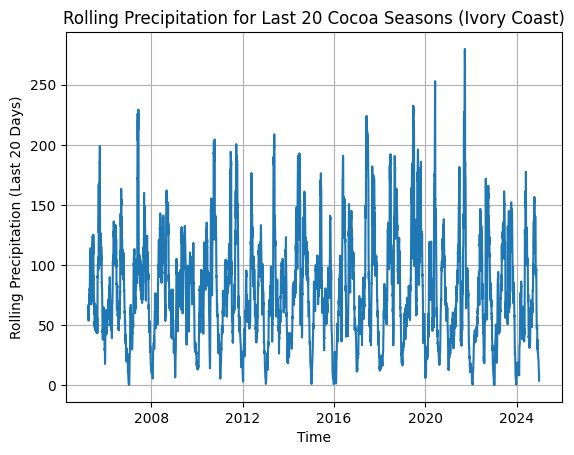

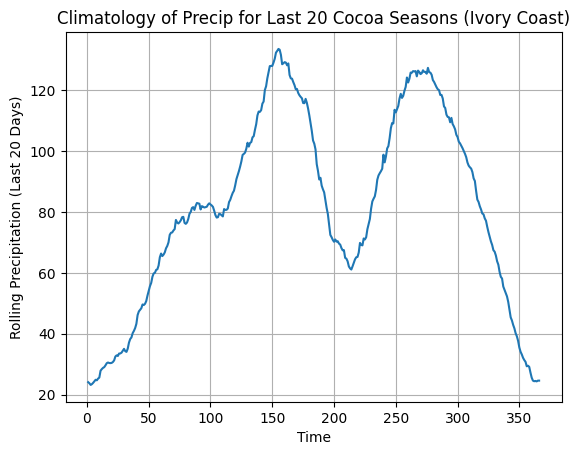

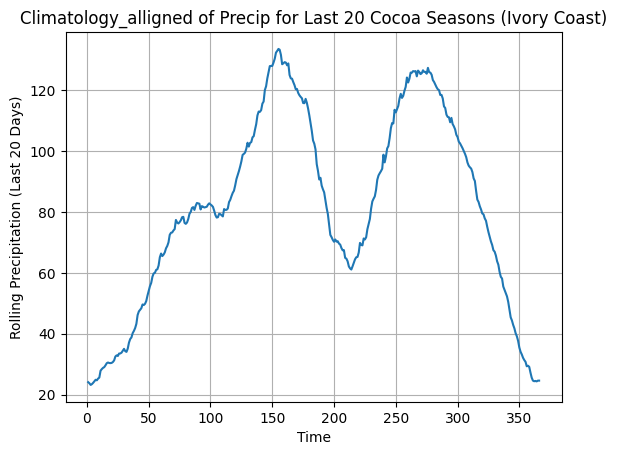

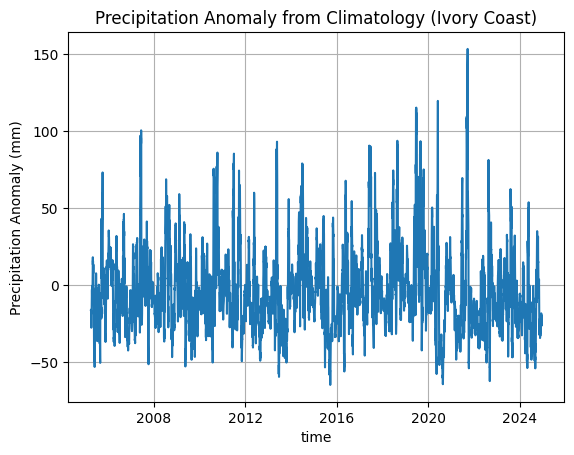

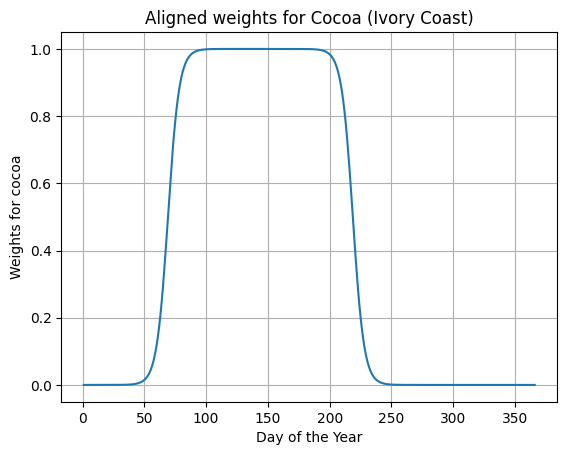

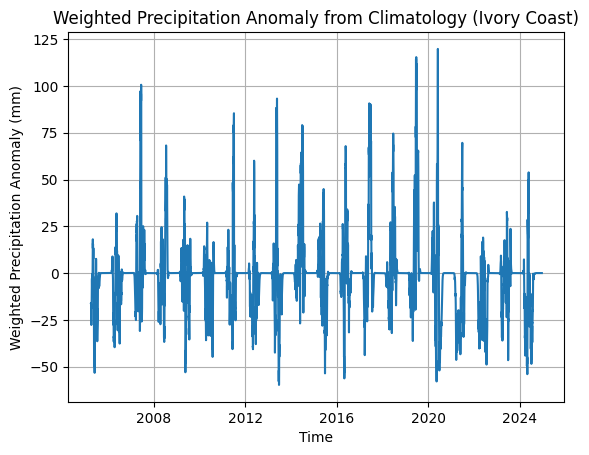

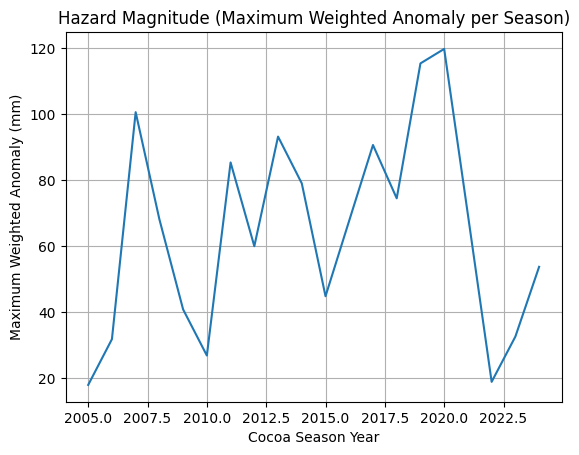

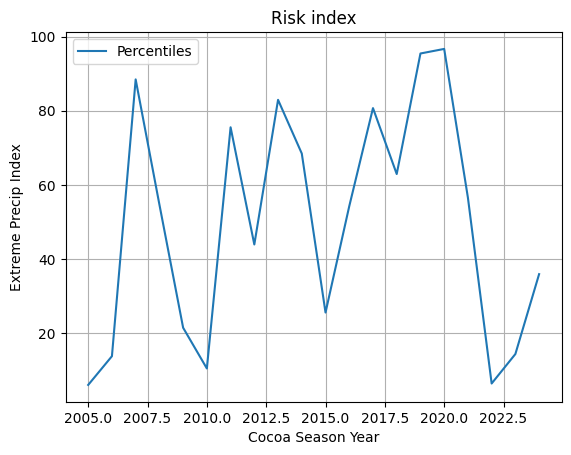

In [ ]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
import numpy as np  # Import numpy and assign it the alias 'np'
drive.mount('/content/drive')
ds = xr.open_dataset('/content/drive/My Drive/met_data.nc')
ivory_data= ds['tp'].sel(latitude=5.7,longitude=-6.1,method='nearest')
#plot=ivory_data.plot()
#plt.show()
Rolling_precipitation=ivory_data.rolling(time=20,center=True).sum()
#plot=Rolling_precipitation.plot()
#plt.show()
# Convert the time coordinate to pandas datetime for easier manipulation
Rolling_precipitation['time'] = pd.to_datetime(Rolling_precipitation['time'].values)

# Define the season year: April 1 to March 31
season_year = (
    Rolling_precipitation['time'].dt.year.where(
        Rolling_precipitation['time'].dt.month >= 4,
        Rolling_precipitation['time'].dt.year - 1
    )
)

# Add season_year as a coordinate
Rolling_precipitation = Rolling_precipitation.assign_coords(season_year=('time', season_year.values))

# Filter data for the last 20 years based on the cocoa season year
current_year = Rolling_precipitation['season_year'].max().values
twenty_years_ago = current_year - 20

# Filter data ensuring full cocoa seasons from April 1 to March 31
filtered_data = Rolling_precipitation.where(
    ((Rolling_precipitation['season_year'] > twenty_years_ago) &
     (Rolling_precipitation['season_year'] <= current_year)),
    drop=True
)

filtered_data['doy'] = filtered_data['time'].dt.dayofyear


# Plot the filtered data
filtered_data.plot()
plt.title("Rolling Precipitation for Last 20 Cocoa Seasons (Ivory Coast)")
plt.xlabel("Time")
plt.ylabel("Rolling Precipitation (Last 20 Days)")
plt.grid(True)
plt.show()



#----------------code for calculating climatology--------------------------


# Group by day of year and take the mean across seasons
climatology = Rolling_precipitation.groupby(Rolling_precipitation['time'].dt.dayofyear).mean()
#print(climatology)

# Rename the 'dayofyear' index to 'doy' (optional)
climatology = climatology.rename({'dayofyear': 'doy'})
# Replace doy=366 value
if 366 in climatology['doy']:
    # Replace with the value for doy=365
    climatology.loc[{'doy': 366}] = climatology.sel(doy=365)

# Plot climatology
climatology.plot()
plt.title("Climatology of Precip for Last 20 Cocoa Seasons (Ivory Coast)")
plt.xlabel("Time")
plt.ylabel("Rolling Precipitation (Last 20 Days)")
plt.grid(True)
plt.show()


# Align the dimensions of filtered_data and climatology based on 'doy'
climatology_broadcasted = climatology.sel(doy=filtered_data.doy, method="nearest")

climatology.plot()
plt.title("Climatology_alligned of Precip for Last 20 Cocoa Seasons (Ivory Coast)")
plt.xlabel("Time")
plt.ylabel("Rolling Precipitation (Last 20 Days)")
plt.grid(True)
plt.show()

# Subtract climatology from the aligned data
anomaly = filtered_data - climatology_broadcasted

#print(anomaly)

# Plot the anomaly
plt.plot(anomaly['time'], anomaly)
plt.title("Precipitation Anomaly from Climatology (Ivory Coast)")
plt.xlabel("time")
plt.ylabel("Precipitation Anomaly (mm)")
plt.grid(True)
plt.show()

# Define Weighting function

def weighting_function(LVP, exp_A, exp_B, I_A_exp, I_B_exp):
  # Shift the fraction of season so April 1 acts as the first day of the cocoa season
	fraction_season =(np.arange(0,LVP+1,1)-90)/LVP
	weighting_function = 1 / (1 + np.exp(-exp_A*(fraction_season - I_A_exp))
				                        + np.exp(exp_B*(fraction_season - I_B_exp)))
	return weighting_function

  # Calculate the weighting function
weights = weighting_function(LVP=365,exp_A = 80, exp_B = 80, I_A_exp = -0.06, I_B_exp = 0.35)

# Ensure the weights array has the same length as the 'doy' coordinate in the anomaly data
weights = weights[:len(anomaly['doy'])]

# Create an xarray DataArray from the weights
weights_da = xr.DataArray(
    weights,
    dims='doy',  # Use the 'doy' dimension
    coords={'doy': np.arange(1, len(weights) + 1)},
    name='weights'
)
#Align the weights with the anomaly
aligned_weights = weights_da.reindex_like(anomaly, method="nearest")

#Plot the weights array to verify

plt.plot(aligned_weights['doy'],aligned_weights)
plt.title("Aligned weights for Cocoa (Ivory Coast)")
plt.xlabel("Day of the Year")
plt.ylabel("Weights for cocoa")
plt.grid(True)
plt.show()

# Multiply the weighting function by the anomaly data for each season
weighted_anomaly = anomaly * aligned_weights.sel(doy=anomaly['doy'])


      # plot or further analyze 'weighted_anomaly' as needed
plt.plot(weighted_anomaly['time'], weighted_anomaly)
plt.title("Weighted Precipitation Anomaly from Climatology (Ivory Coast)")
plt.xlabel("Time")
plt.ylabel("Weighted Precipitation Anomaly (mm)")
plt.grid(True)
plt.show()


# Group the weighted anomaly by season_year
seasonal_anomaly = weighted_anomaly.groupby('season_year')

# Calculate the maximum anomaly for each season
hazard_magnitude = seasonal_anomaly.max()

# plot the hazard magnitude
plt.plot(hazard_magnitude['season_year'], hazard_magnitude)
plt.title("Hazard Magnitude (Maximum Weighted Anomaly per Season)")
plt.xlabel("Cocoa Season Year")
plt.ylabel("Maximum Weighted Anomaly (mm)")
plt.grid(True)
plt.show()

#------Hazard Magnitude into risk index-----------------------
#Fit these values in normal distrbution
from scipy import stats

# Step 1: Flatten hazard_magnitude across all seasons to get a single distribution
hazard_values = hazard_magnitude.values.flatten()

# Step 2: Fit a normal distribution to the data
mu, sigma = np.mean(hazard_values), np.std(hazard_values)

# Step 3: Generate the normal distribution curve
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 1000)
pdf = stats.norm.pdf(x, mu, sigma)

# Step 4: Calculate the percentile for each season's hazard magnitude (using CDF)
season_percentiles = stats.norm.cdf(hazard_magnitude, mu, sigma) * 100  # Convert to percentile

# Step 4: Calculate the percentile for each season's hazard magnitude (using CDF)
percentiles = stats.norm.cdf(hazard_magnitude, mu, sigma) * 100

# Add percentiles as a new variable to the hazard_magnitude dataset
hazard_magnitude = hazard_magnitude.assign_coords({"percentiles": ("season_year", percentiles)})


# Example: Plotting hazard magnitude and percentiles
plt.plot(hazard_magnitude["season_year"], hazard_magnitude["percentiles"], label="Percentiles")
plt.xlabel("Cocoa Season Year")
plt.ylabel("Extreme Precip Index")
plt.title("Risk index")
plt.legend()
plt.grid(True)
plt.show()







